# Lecture 10

## Bagging and Random Forests

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/8cf0cf16" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

The code in the following cell generates the figure you saw on the first slide.

In [ ]:
# generate data
set.seed(123)
data <- data.frame(X = 2*runif(30) - 1)
data$Y <- sin(4*data$X) + .2*rnorm(30)

# load libraries
library(tree)
library(keras)
library(splines)

# fit
f1 <- tree(Y ~ X, data, subset = 1:20, minsize = 2)
f2 <- keras_model_sequential() %>%
        layer_dense(50, activation = "relu", input_shape = c(1)) %>%
        layer_dense(50, activation = "relu", input_shape = c(1)) %>%
        layer_dense(1) %>%
        compile(optimizer = "adam", loss = "mean_squared_error")
fit(f2, data$X[10:30], data$Y[10:30], epochs = 2*10^3, verbose = 0)
f3 <- smooth.spline(data$X[5:25], data$Y[5:25], df = 15)

# predict
grid <- seq(-1, 1, length = 100)
yhat1 <- predict(f1, data.frame(X = grid))
yhat2 <- predict(f2, grid)
yhat3 <- predict(f3, grid)$y
yhat.ensemble <- 1/3 * (yhat1 + yhat2 + yhat3)

# plot
plot(data)
curve(sin(4*x), from = -1, to = 1, add = T, lwd = 3)
lines(grid, yhat1, col = "blue")
lines(grid, yhat2, col = "red")
lines(grid, yhat3, col = "darkgreen")
lines(grid, yhat.ensemble, col = "orange", lwd = 3)
legend(-.6, 1.1, c("tree", "neural net", "spline", "ensemble",
                    "true func."), lty = 1, col = c("blue", "red",
                    "darkgreen", "orange", "black"))

# compare predications
sapply(list(yhat1, yhat2, yhat3, yhat.ensemble),
       function(yhat) mean((yhat - sin(4*grid))^2))

To understand bagging and random forests a bit better we will apply it to the
XOR-problem. The following cell creates the XOR-data, fits a single tree and
plots the result.

In [ ]:
# create data
library(MASS)
set.seed(123)
x1 <- mvrnorm(30, c(1.5, 1), .2*diag(2))
x2 <- mvrnorm(30, c(-1, -1), .2*diag(2))
x3 <- mvrnorm(30, c(-1, .8), .2*diag(2))
x4 <- mvrnorm(30, c(.9, -1), .2*diag(2))
data <- data.frame(X = rbind(x1, x2, x3, x4), Y = c(rep(1, 60), rep(0, 60)))

# fit tree
library(tree)
t <- tree(as.factor(Y) ~ ., data, minsize = 30)
print(t)

# visualize tree
par(mfrow = c(1, 2))
plot(t)
text(t)
plot(data$X.1, data$X.2, col = data$Y + 2)
abline(v = 1.50088, col = 'blue')
lines(c(-3, 1.50088), c(-.460662, -.460662), col = 'blue')
lines(c(-0.0517341, -0.0517341), c(-3, -.460662), col = 'blue')
lines(c(0.950088, 0.950088), c(3, -.460662), col = 'blue')
lines(c(-0.545005, -0.545005), c(3, -.460662), col = 'blue')

Now we use the library `randomForest`.
Recall that bagging is simply a special case of a random forest with $m = p$.
We set $m$ in the code with `mtry`, i.e. to use bagging we set `mtry = 2`,
which is the number of predictors for the XOR data.
We perform bagging with $B$ = `ntree = 10` trees of at most 4 leaf nodes.

In [ ]:
library(randomForest)
bag <- randomForest(as.factor(Y) ~ ., data, mtry = 2, ntree = 10, maxnodes = 4)
for (tree in 1:10) print(getTree(bag, tree, labelVar = T))

As you can see in the output of the cell above, each one of the 10 trees of this
bag performs its first split along the `X.1` direction, roughly at value 1.5,
similarly as we have seen it for the single tree above. This indicates that all
split candidates in the `X.2` direction led to a smaller decrease in the loss.

Now let's see what happens with a random forest, where for each split only one
of the two predictors is considered as split candidate (`mtry = 1`).

In [ ]:
rf <- randomForest(as.factor(Y) ~ ., data, mtry = 1, ntree = 10, maxnodes = 4)
for (tree in 1:10) print(getTree(rf, tree, labelVar = T))

In the output above you can see that some of the trees have their first split in
`X.1` direction, while others have it in `X.2` direction. In this simple
setting, where at each split only one of the predictors is randomly picked as
split candidate, the direction of the first split is entirely determined by this
random selection; no matter what the maximal decrease of a split candidate in
the other direction would have been. Note that within each tree the different
splits can be on different predictors, because the split candidate directions
are randomly selected per node, and not per entire tree.

Next, we apply bagging and random forests to the Heart data.
By default, `randomForest()` uses `p/3` variables when building a random forest
of regression trees, and `√p` variables when building a random forest of
classification trees.  In the cell below we use the `randomForest()` function to
perform both random forests and bagging.

In [ ]:
Heart <-read.csv("http://faculty.marshall.usc.edu/gareth-james/ISL/Heart.csv")[,-1]
Heart <- na.omit(Heart)
Heart$AHD <- as.factor(Heart$AHD)
Heart$ChestPain <- as.factor(Heart$ChestPain)
Heart$Thal <- as.factor(Heart$Thal)
Heart$Sex <- as.factor(Heart$Sex)
library(randomForest)
set.seed(2)
bag <- randomForest(AHD ~ ., Heart, mtry = 13)
rforest <- randomForest(AHD ~ ., Heart)

Let us now split the data an run bagging and random forests only on the test
set and compute the predictions on the test set.

In [ ]:
train <- sample(nrow(Heart), nrow(Heart)/2)
bag <- randomForest(AHD ~ ., Heart, subset = train, mtry = 13)
rf <- randomForest(AHD ~ ., Heart, subset = train)
pred.bag <- data.frame(predict(bag, Heart[-train,], predict.all = T))
pred.rf <- data.frame(predict(rf, Heart[-train,], predict.all = T))

The prediction data frames `pred.bag` and `pred.rf` return the predictions using
the majority vote in the first column (`aggregrate`) and the predictions of each
of the 500 trees in the other columns.

In [ ]:
pred.bag

We define the `error.rate` function to compute the test error based on 2 to 500
trees of all the trees fitted. Instead we could also run the fits with the
`randomForest` function multiple times with the argument `ntree = 2` up to
`ntree = 500` and use the first column of the `predict` function above. Having
fitted already 500 trees, we can instead simply use them and our function
`error.rate` to compute the test error rate for different numbers of trees.

In [ ]:
error.rate <- function(ntree, y, pred) {
    pred <- pred[,seq(2, ntree + 1)] == "Yes"
    maj.vote <- rowMeans(pred) > 0.5
    y <- y == "Yes"
    mean(maj.vote != y)
}
test.err.bag <- sapply(2:500, error.rate, Heart[-train, 'AHD'], pred.bag)
test.err.rf <- sapply(2:500, error.rate, Heart[-train, 'AHD'], pred.rf)

Let us plot the out-of-bag (OOB) and the test error rates.

In [ ]:
plot(bag$err.rate[,1], type = 'l', ylim = c(.15, .35), col = 'darkgreen', ylab = "Error Rate", xlab = "Number of Trees")
lines(rf$err.rate[,1], col = 'orange')
lines(2:500, test.err.bag, col = 'blue')
lines(2:500, test.err.rf, col = 'red')
legend("topright", c("OOB: Bagging","Test: Bagging", "OOB: Random Forest",
                     "Test: Random Forest"),
       col = c('darkgreen', 'blue', 'orange', 'red'), lty = 1)

We see that the random forest has a slightly lower error rate than bagging.

Using the `importance()` function, we can view the importance of each
variable.

In [ ]:
importance(rf)

Plots can be produced with the `varImpPlot()` function.

In [ ]:
varImpPlot(rf)

We see that the Gini index decreases most with splits in variable `Thal`.
(A little bit of background: the variable `Thal` reports the outcome of a
Thallium Stress Test, also known as Nuclear Heart Scan. The outcome of this test
can be "normal", meaning that blood flows normally at rest and during exercise.
The outcome "fixed" means that some area of the heart does not get
enough blood at rest and under stress, whereas the outcome "reversable" means that
some area gets enough blood at rest but not under stress.)

Once you are ready, answer the question on the first page of
[this quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1114498).

## Boosting


In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/3b931392" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

To run boosting we use the library `xgboost`.
Because `xgboost` does not accept data frames we will first convert the data into ordinary matrices.

In [ ]:
library(xgboost)
library(Matrix)
heart.train.x <- sparse.model.matrix(AHD ~ . -1, data = Heart[train,])
heart.test.x = sparse.model.matrix(AHD ~ . -1, data = Heart[-train,])
heart.train.y = Heart[train, "AHD"] == "Yes"
heart.test.y = Heart[-train, "AHD"] == "Yes"

Now we train with the standard binary classification loss `"binary:logistic"`.
For other objective functions see the documentation `?xgboost`.
The arguments of `xgboost` are related to the terminology in the slides as
follows: number of trees `nround` = $B$,
learning rate (or shrinkage parameter) `eta` = $\lambda$,
maximal tree size `max_depth` = $d$

In [ ]:
boost.heart = xgboost(heart.train.x, label = heart.train.y,
                      objective = "binary:logistic",
                      eta = 0.001,
                      max_depth = 4,
                      nround = 10000)

In [ ]:
yhat.boost = predict(boost.heart, heart.test.x)
table(yhat.boost > 0.5, heart.test.y)
mean((yhat.boost > 0.5) != heart.test.y)

The result is comparable to the one with Random Forests.

Also in xgboost we can look at the importance plot.

In [ ]:
xgb.plot.importance(xgb.importance(model = boost.heart))

In the following you see the code of the comparison between the different
methods. We use the `Boston` housing data set. The function `getdata` in the
following cell returns reproducible training and test splits that we will use
later.

In [ ]:
library(MASS)
getdata <- function (seed = 1) {
    set.seed(seed)
    train = sample(1:nrow(Boston), nrow(Boston)/2)
    list(train = train,
         boston.test = Boston[-train,"medv"],
         boston.train.x = as.matrix(Boston[train, names(Boston) != "medv"]),
         boston.test.x = as.matrix(Boston[-train, names(Boston) != "medv"])
    )
}

In the next cell we fit bagging, random forests and linear regression on 50
different splits of the data. Have a look at `?with`, if you wonder what it
does.

In [ ]:
library(randomForest)
fit.and.evaluate <- function(seed = 1, method = randomForest, ...) {
    with(getdata(seed), {
             rf <- method(medv ~ ., Boston[train,], ...)
             pred <- predict(rf, Boston[-train,])
             mean((pred - Boston[-train,"medv"])^2)
    })
}
rf.res <- sapply(1:50, fit.and.evaluate)
bag.res <- sapply(1:50, fit.and.evaluate, mtry = 13)
lm.res <- sapply(1:50, fit.and.evaluate, method = lm)

Next we do the same for boosting...

In [ ]:
library(xgboost)
boost.func <- function(seed = 1) {
    with(getdata(seed), {
        boston.train.xgb <- xgb.DMatrix(boston.train.x,
                                   label = Boston[train, "medv"])
        boston.test.xgb <- xgb.DMatrix(boston.test.x,
                                   label = Boston[-train, "medv"])
        boost.boston <- xgb.train(data = boston.train.xgb,
                                 nround = 2000,
                                 max_depth = 4,
                                 eta = 0.005,
                                 verbose = 0,
                                 watchlist = list(train = boston.train.xgb,
                                                  test = boston.test.xgb),
                                 objective = "reg:squarederror")
        yhat.boston <- predict(boost.boston, boston.test.xgb)
        mean((yhat.boston - boston.test)^2)
    })
}
boost.res <- sapply(1:50, boost.func)

... and for neural networks. Here we go additionally through the hassle of
scaling the data appropriately.

In [ ]:
library(keras)
get.scale <- function(scaled) {
    if ("scaled:center" %in% names(attributes(scaled))) {
        center <- attr(scaled, "scaled:center")
    } else {
        center <- rep(0, ncol(scaled))
    }
    if ("scaled:scale" %in% names(attributes(scaled))) {
        list(center, attr(scaled, "scaled:scale"))
    } else {
        list(center, rep(1., length(center)))
    }
}
boston.x.scale <- function(x, scaled) {
    s <- get.scale(scaled)
    centered <- sweep(x, 2, s[[1]])
    sweep(centered, 2, s[[2]], FUN = "/")
}
boston.y.scale <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}
boston.y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}
keras.func <- function (seed = 1) {
    with(getdata(seed), {
        boston.train.x.prep <- scale(boston.train.x, center = T, scale = T)
        boston.train.y.prep <- scale(Boston[train, "medv"], center = T, scale = T)
        nn <- keras_model_sequential()
        nn <- nn %>%
            layer_dense(200, activation = "relu", input_shape = c(13)) %>%
            layer_dropout(rate = .25) %>%
            layer_dense(200, activation = "relu") %>%
            layer_dropout(rate = .25) %>%
            layer_dense(1, activation = "linear")
        nn %>% compile(optimizer = "adam", loss = "mean_squared_error")
        history <- nn %>% fit(boston.train.x.prep,
                             boston.train.y.prep,
                             verbose = 0,
                             batch_size = length(boston.train.y.prep),
                             validation_data = list(boston.x.scale(boston.test.x, boston.train.x.prep),
                                                    boston.y.scale(boston.test, boston.train.y.prep)),
                             epochs = 500)
        nn.pred <- predict(nn, boston.x.scale(boston.test.x, boston.train.x.prep))
        mean((boston.y.unscale(nn.pred, boston.train.y.prep) - boston.test)^2)
    })
}
keras.res <- sapply(1:50, keras.func)

After all this, let us produce the summary plot.

In [ ]:
res <- data.frame(boost = boost.res, keras = keras.res,
                  rforest = rf.res, bag = bag.res, linreg = lm.res)
boxplot(res, ylab = "test error")

Now you can answer the question on the second page of
[this quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1114498).

## Beyond Supervised Learning

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/0e17cfca" frameborder="0" allow="fullscreen" allowfullscreen></iframe>')

There is no code for this section.

## Exercises
## Conceptual

**Q1.**
We want to classify red versus blue points.
The numbers next to the data point indicate the index of the data point in the
training set, e.g. the 5th point of the training set has $X_1 = 2, X_2 = 2, Y =
\mbox{"blue"}$

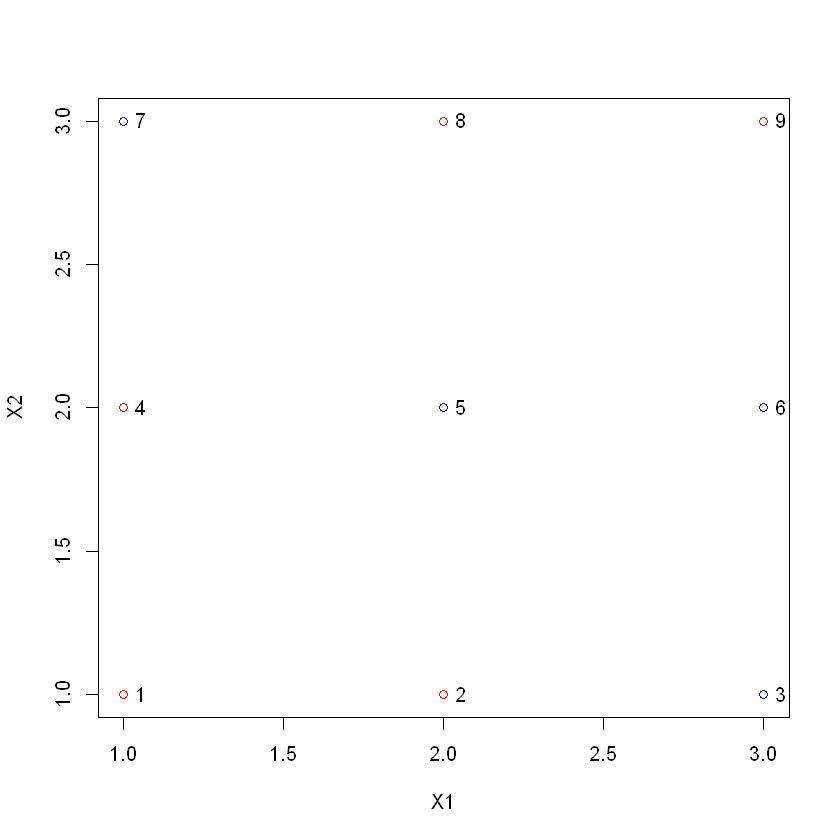

In [1]:
plot(c(1, 2, 3, 1, 2, 3, 1, 2, 3), c(1, 1, 1, 2, 2, 2, 3, 3, 3),
     col = c("red", "blue")[c(1, 1, 2, 1, 2, 2, 2, 1, 1)],
     xlab = "X1", ylab = "X2")
text(c(1, 2, 3, 1, 2, 3, 1, 2, 3), c(1, 1, 1, 2, 2, 2, 3, 3, 3),
     seq(1, 9), pos = 4)

a) Compute the entropy loss of the whole data set without considering a split.
Use the logarithm $\log_2$ with base 2 to compute the entropy.

b) Compute the Gini index for the same setting.

c) Find the split that maximally reduces the entropy loss and compute the
reduction in loss and the value of the leaf nodes.
Make sure to weight the contributions to the reduction in loss of the different
regions with the number of data points they contain.

d) Consider bagging with bootstrap training sets $b_1 = \{1, 2, 3, 4, 5, 6, 7,
8, 8\}$ and $b_2 = \{1, 2, 3, 4, 5, 6, 6, 7, 8\}$. Where are the first splits of
the trees fitted to $b_1$ and $b_2$, respectively?

e) Compute the out-of-bag test error estimate for the bagged trees in d)

f) Consider a Random Forest with $m=1$ and the same bootstrap training sets as
in d).  Are the first splits of the two trees in this Random Forest at the same
place as in bagging? Justify your answer.

**Q2.**
We want to apply boosting to the following regression problem.
This time, the numbers next to the data points indicate the value of the
response, e.g. our training set contains a data point with $X_1 = 1, X_2 = 1, Y = 1$.

In [ ]:
plot(c(1, 2, 3, 4), c(1, 4, 3, 2), xlab = "X1", ylab = "X2")
text(c(1, 2, 3, 4), c(1, 4, 3, 2), c(1, 3, 5, 7), pos = 4)

We choose $d = 1$, $B = 2$ and $\lambda = 0.5$. Follow the boosting algorithm
outlined in the slides of the lecture (it differs in the initialization from
algorithm 8.2 from the book).

a) Compute $f_0(X_1,X_2)$

b) Compute the residuals and determine the splits and leaf values of the first
tree and write $f_1(X_1,X_2)$ explicitly.

c) Compute the residuals and determine the splits and leaf values of the second
tree and write $f_2(X_1,X_2)$ explicitly.

## Applied

**Q3.**
We now use boosting to predict `Salary` in the `Hitters` data set.
The `Hitters` data is in `library(ISRL)`.

a) Remove the observations for whom the salary information is unknown, and then
log-transform the salaries.

b) Create a training set consisting of the first 200 observations, and a test
set consisting of the remaining observations.

c) Perform boosting on the training set with 1000 trees for a range of values of
the learning rate $\lambda$. Produce a plot with different learning rate
values on the $x$-axis and the corresponding training set MSE on the $y$-axis.

d) Produce a plot with different learning rate values on the $x$-axis and the
corresponding test set MSE on the $y$-axis.

e) Compare the test MSE of boosting to the test MSE that results from applying
linear regression.

f) Which variables appear to be the most important predictors in the boosted
model?

g) Now apply bagging to the training set. What is the test set MSE for this
approach?

**Q4.**
Use boosting to classify images in the Histopathalogic Cancer Detection data set
that we studied in the last exercise of sheet 7* - part 2. Try different
parameter values for $B$, $\lambda$ and $d$. To tell R that the 0s and 1s in
`PCaml_y` should be treated as values of a categorical response, you may use
`PCaml_y <- as.factor(PCaml_y)`. Compare your results to the ones obtained with
logistic regression and convolutional networks. Which are the important factors (pixels)?
